In [1]:
import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK']='1' # For M1 architectures

import fastai
from fastai.vision.all import *
from pathlib import Path
import numpy as np
import torch

from tqdm.notebook import tqdm, trange
from PIL import Image
import pandas as pd
from skimage.measure import label, regionprops_table
from skimage.morphology import binary_erosion, disk, white_tophat
from skimage.filters import sobel
from tifffile import tifffile
import skimage

import matplotlib.pyplot as plt

import torchvision.transforms.v2 as transforms

In [2]:
bs = 32 # On CPU, so lets keep the batch size small
device = torch.device("mps")

In [3]:
# Some helper functions
def load_test_crops(image_root):
    png_paths = [ x for x in image_root.glob("*.png") if x.name[0] != "." ]
    pngs = [ np.array(Image.open(x)) for x in png_paths ]
    ground_truths = [ np.array(Image.open(x / "../../annotations/{name}".format(name=x.name))) for x in png_paths ]

    return pngs, ground_truths

## Predicting cell crops
The micronucleus neural net expects crops centered on the nucleus that are 96x96 in size

In [4]:
test_root = Path('./training-data/rpe-1/test')
crops, truth = load_test_crops(test_root)

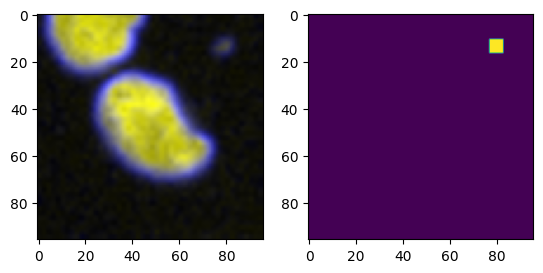

In [5]:
f, ax = plt.subplots(1,2)
ax[0].imshow(crops[0])
ax[1].imshow(truth[0])

In [6]:
def label_func(x):
    return x.parent.parent / 'annotations/{}.png'.format(x.stem)
    
learn18 = load_learner(Path('./models-exported/2024-10-19/export.pkl'))

In [7]:
normalize = transforms.Normalize(*imagenet_stats)
prediction = np.argmax(learn18.predict(normalize(crops[0]))[2], axis=0).numpy()

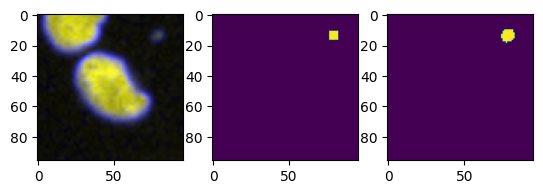

In [8]:
f, ax = plt.subplots(1,3)
ax[0].imshow(crops[0])
ax[1].imshow(truth[0])
ax[2].imshow(prediction)

## Predicting whole fields
To predict across a whole field, you will need to rely on your nucleus segmenter of choice to first find the nuclei, then generate crops centered on each predicted nucleus. The below code also includes the workflow outlined in the [VCS paper](https://elifesciences.org/reviewed-preprints/101579).

### 1) Load a field of H2B-tagged RPE-1 cells

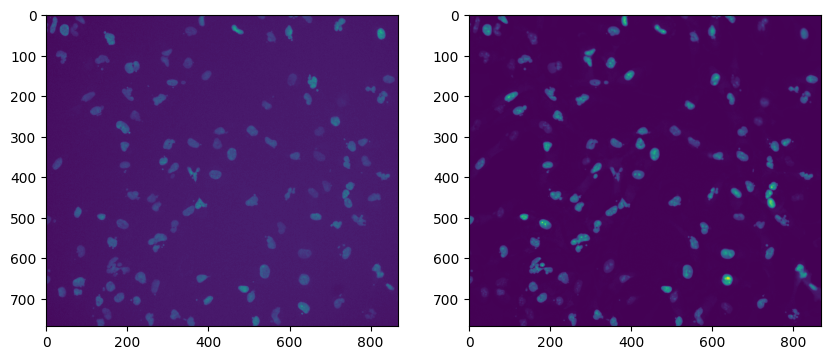

In [9]:
h2b = tifffile.imread("training-data/rpe-1/full-field/w1.TIF")
dendra2 = tifffile.imread("training-data/rpe-1/full-field/w2.TIF")
norm_dendra2 = white_tophat(skimage.img_as_ubyte(dendra2).astype(np.uint8), disk(20))
f, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(h2b)
ax[1].imshow(norm_dendra2)

### 2) Find nuclei
The nucleus segmenter used in the paper was based on [Deep Retina](https://github.com/Lopezurrutia/DSB_2018), an Mask R-CNN neural net that took 3rd place in the 2018 Kaggle Data Science Bowl for segmenting nuclei. This was based on TensorFlow 1.3, which is now outdated and may be difficult to install on a modern version of Python. We could use the cell segmenter built into MNFinder, but this is not purpose-built for only finding nuclei and also relies on TensorFlow, whereas the VCS neural net uses the PyTorch-based FastAI library. 

To keep everything in the “PyTorch” family, we will use [CellPose](https://www.cellpose.org) for this demonstration. To maximize speed, you should determine what nucleus segmenter works best for your use case.

/Users/luciandipeso/Documents/Hatch-Lab/Tools/fast-mn/.env/lib/python3.12/site-packages/cellpose/resnet_torch.py:280: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dic

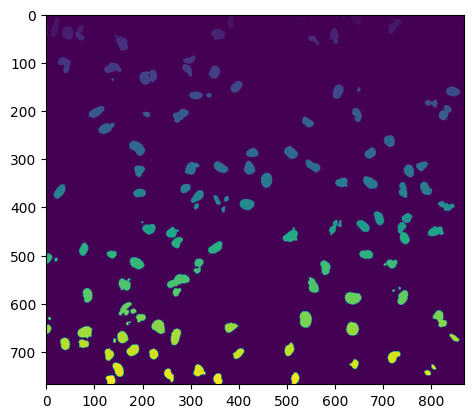

In [10]:
from cellpose import models
model = models.Cellpose(model_type='nuclei')
channels = [[0,0]]
nuc_masks, flows, styles, diams = model.eval(h2b, diameter=None, channels=channels)
plt.imshow(nuc_masks)

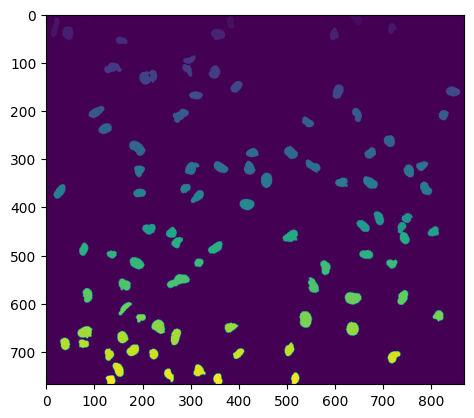

In [11]:
nuc_info = pd.DataFrame(regionprops_table(nuc_masks, norm_dendra2, properties=('label', 'centroid', 'area', 'intensity_max'))).\
    rename(columns={'label': 'nuc_label', 'centroid-0': 'y', 'centroid-1': 'x', 'intensity_max': 'nuc_dendra_intensity'})

# Ignore nuclei that are probably MN
np.max(nuc_info['area'])
nuc_info = nuc_info.loc[nuc_info['area'] >= 250].reset_index(drop=True)

nuc_masks[~np.isin(nuc_masks, nuc_info['nuc_label'].unique())] = 0
plt.imshow(nuc_masks)

### 3) Generate crops
Generate 48x48 px crops centered at each nucleus, then scale this image up by 2.

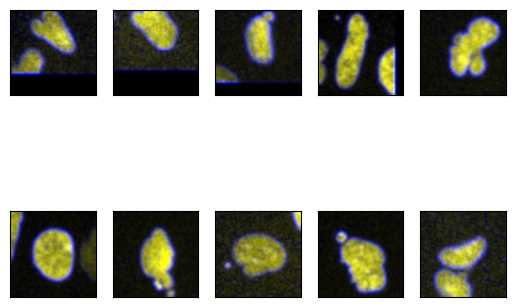

In [13]:
from skimage.filters import sobel
from skimage.transform import rescale

def normalize_image(img):
    percentile = 99.9
    high = np.percentile(img, percentile)
    low = np.percentile(img, 100-percentile)

    img = np.minimum(high, img)
    img = np.maximum(low, img)

    img = (img - low) / (high - low) # gives float64, recast as 8-bit
    img = skimage.img_as_ubyte(img)

    return img

norm_h2b = normalize_image(h2b)
nn_inputs = []
input_coords = []
crop_size = 48
rescale_factor = 2
for i,row in nuc_info.iterrows():
    crop = np.zeros((crop_size,crop_size), dtype=np.uint8)
    
    left = round(row['x']-crop_size//2)
    right = round(row['x']+crop_size//2)
    top = round(row['y']-crop_size//2)
    bottom = round(row['y']+crop_size//2)

    if left < 0:
        left = 0
    if right > h2b.shape[1]:
        right = h2b.shape[1]

    if top < 0:
        top = 0
    if bottom > h2b.shape[0]:
        bottom = h2b.shape[0]

    crop[0:(bottom-top),0:(right-left)] = normalize_image(norm_h2b[top:bottom,left:right])
    nn_inputs.append(
        rescale( # Rescale to the size expected by the VCS neural net (96x96)
            np.stack([ crop, crop, normalize_image(sobel(crop)) ], axis=-1), # Generate 3-channel image with sobel
            (rescale_factor,rescale_factor,1), 
            anti_aliasing=False,
            preserve_range=True
        ).astype(np.uint8)
    )
    input_coords.append([ top, right, bottom, left ]) # Remember for mapping back to full size image

f,ax = plt.subplots(2,5)
for i in range(10):
    col = i % 5
    row = math.floor(i/5)
    ax[row][col].imshow(nn_inputs[i])
    ax[row][col].set_xticks([])
    ax[row][col].set_yticks([])

In [14]:
dl = learn18.dls.test_dl(nn_inputs, bs=bs) # apply transforms
predictions, _ = learn18.get_preds(dl=dl) # get prediction
predictions = np.argmax(predictions.numpy(), axis=1) # Get the class
 # Rescale back to 48x48
predictions = rescale(predictions, (1, 1/rescale_factor, 1/rescale_factor), anti_aliasing=False, preserve_range=True).astype(np.uint8)

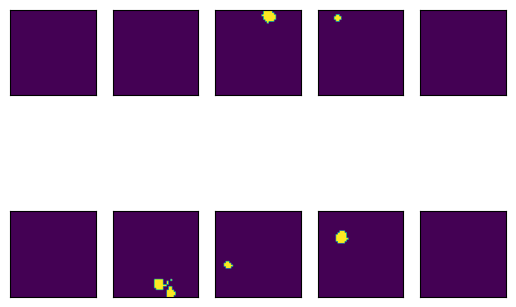

In [15]:
f,ax = plt.subplots(2,5)
for i in range(10):
    col = i % 5
    row = math.floor(i/5)
    ax[row][col].imshow(predictions[i])
    ax[row][col].set_xticks([])
    ax[row][col].set_yticks([])

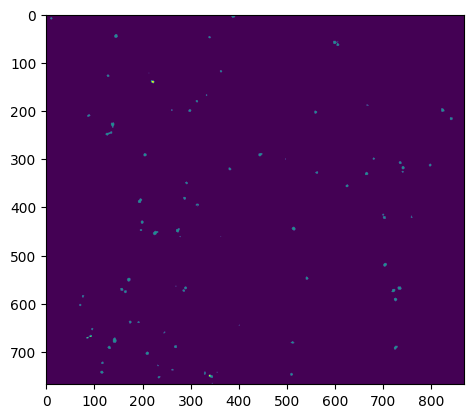

In [16]:
field_prediction = np.zeros_like(h2b, dtype=np.uint8)
for i, coords in enumerate(input_coords):
    top, right, bottom, left = coords
    field_prediction[top:bottom, left:right] += predictions[i,0:bottom-top, 0:right-left]
plt.imshow(field_prediction)

### 4) Assign MN to nuclei

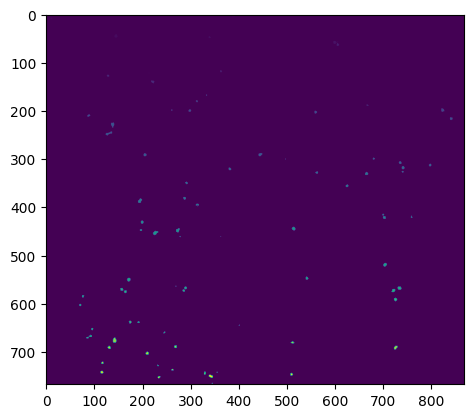

In [17]:
from scipy.spatial import KDTree

nuc_kdtree = KDTree(list(zip(nuc_info['x'].tolist(), nuc_info['y'].tolist())))

labelled_mn = label(field_prediction, connectivity=1)
plt.imshow(labelled_mn)

In [18]:
mn_info = pd.DataFrame(regionprops_table(labelled_mn, norm_dendra2, properties=('label', 'centroid', 'intensity_max'))).\
    rename(columns={'label': 'mn_label', 'centroid-0': 'y', 'centroid-1': 'x', 'intensity_max': 'mn_dendra_intensity' })
mn_info

,mn_label,y,x,mn_dendra_intensity
0,1,3.615385,387.666667,67.0
1,2,8.500000,10.500000,7.0
2,3,45.162162,144.702703,20.0
3,4,47.642857,338.785714,19.0
4,5,58.451613,598.290323,34.0
...,...,...,...,...
95,96,750.363636,339.090909,17.0
96,97,751.920000,342.800000,27.0
97,98,753.266667,233.933333,27.0
98,99,752.000000,338.000000,10.0


In [19]:
nuc_distances = nuc_kdtree.query(list(zip(mn_info['x'].tolist(), mn_info['y'].tolist())), k=1)
mn_info['nearest_nuc_idx'] = nuc_distances[1]
mn_info['nearest_nuc_distance'] = nuc_distances[0]
mn_info

,mn_label,y,x,mn_dendra_intensity,nearest_nuc_idx,nearest_nuc_distance
0,1,3.615385,387.666667,67.0,2,14.368395
1,2,8.500000,10.500000,7.0,3,20.855593
2,3,45.162162,144.702703,20.0,8,14.904794
3,4,47.642857,338.785714,19.0,7,18.478589
4,5,58.451613,598.290323,34.0,6,16.763491
...,...,...,...,...,...,...
95,96,750.363636,339.090909,17.0,92,18.353143
96,97,751.920000,342.800000,27.0,92,14.332554
97,98,753.266667,233.933333,27.0,90,21.429210
98,99,752.000000,338.000000,10.0,92,18.874826


In [20]:
# Merge in nuclear info
nuc_mn_info = mn_info.merge(nuc_info[['nuc_label', 'nuc_dendra_intensity']], left_on='nearest_nuc_idx', right_index=True, how='left')
nuc_mn_info

,mn_label,y,x,mn_dendra_intensity,nearest_nuc_idx,nearest_nuc_distance,nuc_label,nuc_dendra_intensity
0,1,3.615385,387.666667,67.0,2,14.368395,7,133.0
1,2,8.500000,10.500000,7.0,3,20.855593,8,34.0
2,3,45.162162,144.702703,20.0,8,14.904794,20,35.0
3,4,47.642857,338.785714,19.0,7,18.478589,15,77.0
4,5,58.451613,598.290323,34.0,6,16.763491,14,107.0
...,...,...,...,...,...,...,...,...
95,96,750.363636,339.090909,17.0,92,18.353143,152,79.0
96,97,751.920000,342.800000,27.0,92,14.332554,152,79.0
97,98,753.266667,233.933333,27.0,90,21.429210,149,81.0
98,99,752.000000,338.000000,10.0,92,18.874826,152,79.0


In [21]:
# Filter any MN that are more than 40 px away from nucleus
nuc_mn_info = nuc_mn_info.loc[nuc_mn_info['nearest_nuc_distance'] <= 40]

# Filter any MN that are overlapping with eroded nuclear masks
eroded_nuc_masks = binary_erosion((nuc_masks > 0), disk(2))
nuc_mn_info['in_nucleus'] = nuc_mn_info.apply(lambda r: eroded_nuc_masks[round(r['y']),round(r['x'])], axis=1)
nuc_mn_info = nuc_mn_info.loc[~nuc_mn_info['in_nucleus']]

# Determine rupture status of MN
nuc_mn_info['dendra_ratio'] = nuc_mn_info['mn_dendra_intensity']/nuc_mn_info['nuc_dendra_intensity']
nuc_mn_info['ruptured'] = nuc_mn_info['dendra_ratio'] > 0.16 
nuc_mn_info

,mn_label,y,x,mn_dendra_intensity,nearest_nuc_idx,nearest_nuc_distance,nuc_label,nuc_dendra_intensity,in_nucleus,dendra_ratio,ruptured
0,1,3.615385,387.666667,67.0,2,14.368395,7,133.0,False,0.503759,True
1,2,8.500000,10.500000,7.0,3,20.855593,8,34.0,False,0.205882,True
2,3,45.162162,144.702703,20.0,8,14.904794,20,35.0,False,0.571429,True
3,4,47.642857,338.785714,19.0,7,18.478589,15,77.0,False,0.246753,True
4,5,58.451613,598.290323,34.0,6,16.763491,14,107.0,False,0.317757,True
...,...,...,...,...,...,...,...,...,...,...,...
95,96,750.363636,339.090909,17.0,92,18.353143,152,79.0,False,0.215190,True
96,97,751.920000,342.800000,27.0,92,14.332554,152,79.0,False,0.341772,True
97,98,753.266667,233.933333,27.0,90,21.429210,149,81.0,False,0.333333,True
98,99,752.000000,338.000000,10.0,92,18.874826,152,79.0,False,0.126582,False


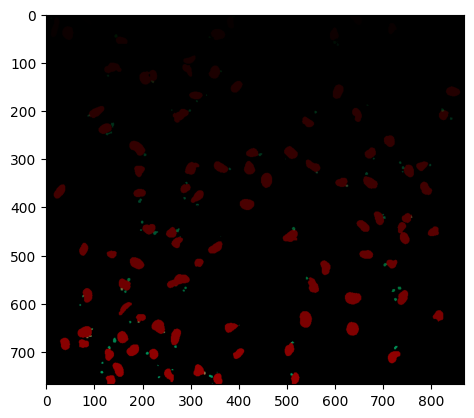

In [22]:
# Final predictions
final_field_prediction = np.zeros((field_prediction.shape[0], field_prediction.shape[1], 3), np.uint16)
final_field_prediction[...,0] = nuc_masks
for i, row in nuc_mn_info.iterrows():
    final_field_prediction[labelled_mn == row['mn_label'],1] = row['nuc_label']
    final_field_prediction[labelled_mn == row['mn_label'],2] = row['mn_label']

plt.imshow(final_field_prediction)

In [23]:
nuc_info['mn+'] = np.isin(nuc_info['nuc_label'], nuc_mn_info['nuc_label'])
nuc_info

,nuc_label,y,x,area,nuc_dendra_intensity,mn+
0,1,11.811550,84.063830,329.0,93.0,False
1,5,9.733681,643.791123,383.0,93.0,False
2,7,17.003333,382.450000,300.0,133.0,True
3,8,27.669663,18.714607,445.0,34.0,True
4,10,29.494662,717.039146,281.0,40.0,False
...,...,...,...,...,...,...
89,147,740.021077,316.772834,427.0,97.0,True
90,149,748.692737,254.868715,358.0,81.0,True
91,151,755.936306,516.388535,314.0,84.0,True
92,152,757.014881,356.196429,336.0,79.0,True


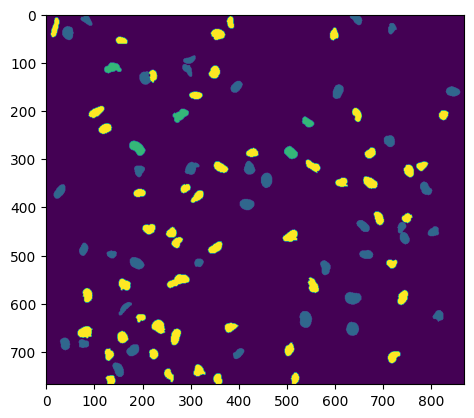

In [24]:
# MN+/-, Rupture+/-
mnated_field_prediction = np.zeros_like(field_prediction, dtype=np.uint8)
mnated_field_prediction[nuc_masks > 0] = 1
mnated_field_prediction[np.isin(nuc_masks, nuc_info.loc[nuc_info['mn+'],'nuc_label'])] = 2
mnated_field_prediction[np.isin(nuc_masks, nuc_mn_info.loc[nuc_mn_info['ruptured'], 'nuc_label'])] = 3
plt.imshow(mnated_field_prediction)